## Implementation of K-means algorithm and adaptation to streaming

## <span style="color:red;" style=" font-size:50px;">  This notebook was completed by Gurami Keretchashvili, Temur Malishava and Guillaume Barthe  </span>


In [1]:
from sklearn.tree import DecisionTreeClassifier
from river.utils import dict2numpy
from kneed import KneeLocator
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, scale
from sklearn.metrics import confusion_matrix,recall_score, precision_score,f1_score,silhouette_score
from IPython.display import clear_output
from matplotlib.lines import Line2D
import time
import numpy as np
import scipy.io
from scipy.spatial import distance
from river.stream import iter_pandas
from river import metrics
import sys

In [2]:
class Kmeans_clustering:
    def __init__(self, window_size = 300):
        self.window_size = window_size
        self.X_batch = []
        self.Y_batch = []
        self.outliers = []
        self.n_clusters = 0
        self.X_new = []
        self.centroids=[]
        self.counter = 0
        self.old_update = 0
        
    def update_optimal_cluster(self, max_k,X):
        """
        initialize optimal clusters when 300 data points are fed and update it every one every 100 new data points come in.
        input: max number of clusters
        
        output: optimal values of clusters
        """
        if (len(X)== self.window_size):
            Sum_of_squared_distances = []
            K = range(1,max_k)
            for k in K:
                km = KMeans(n_clusters=k)
                km = km.fit(X)
                Sum_of_squared_distances.append(km.inertia_)
            kn = KneeLocator(K, Sum_of_squared_distances, curve='convex', direction='decreasing')
            print("Number of clusters = ", kn.knee)
            self.n_clusters =kn.knee
            
            return self.n_clusters
        return self.n_clusters
    
    def detect_outliers(self,kmean,labels,centroids):
        """
        detects outliers at any discrete time moment. 
                
        """
        self.outliers = []
        center = centroids
        # !! Get the indices of the points for each corresponding cluster
        mydict = {i: np.where(np.array(labels) == i)[0] for i in range(kmean.n_clusters)} 
        # Transform the dictionary into list
        dictlist = []
        for key, value in mydict.items():
            temp = [key,value]
            dictlist.append(temp)
            
        all_distances  = []
        for cluster_i in range(self.n_clusters):
            centroid_i = centroids[cluster_i]
            
            distances_from_centroid_i = []

            for point in dictlist[cluster_i][1]:
                point_i = [self.X_new[0][point],self.X_new[1][point]]
                try:
                    distances_from_centroid_i.append(distance.euclidean(centroid_i,point_i))
                except:
                    print(centroid_i, point_i,centroids)
            all_distances.append(distances_from_centroid_i)

        all_distances = [np.array(x) for x in all_distances]
        output = [(x > np.percentile(x, 96)) for x in all_distances]
        output = [x.astype(int) for x in output]

        dictlistance_index = []
        for i in range(self.n_clusters):
            dictlistance_index.append(list(zip(dictlist[i][1],all_distances[i],output[i])))
        
        for x in dictlistance_index:
            for i in x:
                if (i[-1]==1):
                    self.outliers.append(i)


    
    def learn_one(self, x, y=None):
        """
        learns the model, detect outliers and produce visualization
        """
        x = dict2numpy(x)
        
        if len(self.X_batch) < self.window_size:
            self.X_batch.append(x)
            self.Y_batch.append(y)
        else:
            self.X_batch.pop(0)
            self.Y_batch.pop(0)
            self.X_batch.append(x)
            self.Y_batch.append(y)
            X_std = StandardScaler().fit_transform(self.X_batch)
            pca = PCA(n_components=x.shape[0])
            principalComponents = pca.fit_transform(X_std)
            PCA_components = pd.DataFrame(principalComponents)
            self.X_new = PCA_components.iloc[:,:2]
            
            self.counter+=1
            #print(self.counter)
            if self.counter == 1 or self.counter % 100 == 0:
                k_opt = self.update_optimal_cluster(15,self.X_new)
                self.old_update = k_opt
            k_opt = self.old_update
        
            kmean = KMeans(n_clusters=k_opt)
            kmean.fit(self.X_new)
            centroids = kmean.cluster_centers_
            
            if len (self.centroids) != len(centroids):
                self.centroids = centroids
                self.n_clusters = len(centroids)
            
            closest_index = []
                
            for c in centroids:
                distances = []
                for u in self.centroids:
                    distances.append(distance.euclidean(c,u))
                while np.argmin(distances) in closest_index:
                        distances[np.argmin(distances)]=100
                closest_index.append(np.argmin(distances))
                    
            
            
            new_centroids = [centroids[np.where(np.array(closest_index)==i)[0]] for i in range(len(centroids))]
            
            self.centroids = new_centroids
            colors = ['#DF2020', '#81DF20', '#2095DF','#DF6a20','#18D19E',"#D19618"]
            interm_labels = []
            for u in kmean.labels_:
                interm_labels.append(closest_index[u])
            new_labels = []
            for u in kmean.labels_:
                new_labels.append(colors[closest_index[u]])
                    
            self.detect_outliers(kmean,interm_labels,new_centroids)
            
            outliers_index = [u[0] for u in self.outliers]
            
            L_no_outliers = []
            L_outliers = []
            X_no_outliers = []
            X_outliers = []
            Y_no_outliers = []
            Y_outliers = []
            X_centroids = [u[0][0] for u in new_centroids]
            Y_centroids = [u[0][1] for u in new_centroids]
          
            
            for i in range(len(self.X_new[0])):
                if i in outliers_index:
                    X_outliers.append(self.X_new[0][i])
                    Y_outliers.append(self.X_new[1][i])
                    L_outliers.append(new_labels[i])
                else:
                    X_no_outliers.append(self.X_new[0][i])
                    Y_no_outliers.append(self.X_new[1][i])
                    L_no_outliers.append(new_labels[i])
            
            
            clear_output(wait=True)
            
            legend_elements = [Line2D([0], [0], marker='o', color='w', label='Cluster {}'.format(i+1), 
                   markerfacecolor=mcolor, markersize=5) for i, mcolor in enumerate(colors[:len(new_centroids)])]
            legend_elements.extend([Line2D([0], [0], marker='^', color='w', label='Centroid - C{}'.format(i+1), 
            markerfacecolor=mcolor, markersize=10) for i, mcolor in enumerate(colors[:len(new_centroids)])])
            legend_elements.extend([Line2D([0], [0], marker=r'$\odot$', color='w', label='Anomaly - C{}'.format(i+1), 
            markerfacecolor=mcolor, markersize=10) for i, mcolor in enumerate(colors[:len(new_centroids)])])
            #legend_elements.extend(cent_leg)
            
            for idx, val in enumerate(X_no_outliers):
                #print(new_centroids[np.where(np.array(colors)==L_no_outliers[idx])[0][0]])
                x = [val,new_centroids[np.where(np.array(colors)==L_no_outliers[idx])[0][0]][0][0]]
                y = [Y_no_outliers[idx], new_centroids[np.where(np.array(colors)==L_no_outliers[idx])[0][0]][0][1]]
                #print(x,y)
                plt.plot(x, y, c=L_no_outliers[idx], alpha=0.2)
    
            plt.scatter(X_no_outliers,Y_no_outliers,c=L_no_outliers)
            plt.scatter(X_outliers,Y_outliers,c=L_outliers,s=250,marker=r'$\odot$',facecolors='none')
            plt.scatter(X_centroids, Y_centroids, marker='^', c=[colors[i] for i in range(len(new_centroids))], s=110)
            plt.grid(False)
            plt.gcf().set_size_inches((12, 12))
            
            plt.legend(handles=legend_elements, loc='upper right', ncol=3)
            plt.show()
            return len(self.outliers)
        return 0

In [3]:
# from river.tree import HoeffdingTreeClassifier
# from river.neighbors import KNNClassifier



def print_progress(sample_id, acc, kappa,train_time_avg,train_time_total,test_time_avg,test_time_total):
    print(f'Samples processed: {sample_id}')
    print(acc)
    print(kappa)
    print(f'Training Time Average : {train_time_avg}')
    print(f'Testing Time Average : {test_time_avg}')
    print(f'Training Time Total : {train_time_total}')
    print(f'Testing Time Total : {test_time_total}')

def evaluate(stream, model, n_wait=1000, verbose=False):
    acc = metrics.Accuracy()
    acc_rolling = metrics.Rolling(metric=metrics.Accuracy(), window_size=n_wait)
    kappa = metrics.CohenKappa()
    kappa_rolling = metrics.Rolling(metric=metrics.CohenKappa(), window_size=n_wait)
    raw_results = []
    model_name = model.__class__.__name__
    train_time = []
    for i, (x, y) in enumerate(stream):
        # Predict
        #y_pred = model.predict_one(x)

        # Update metrics and results
        #acc.update(y_true=y, y_pred=y_pred)
        #acc_rolling.update(y_true=y, y_pred=y_pred)
        #kappa.update(y_true=y, y_pred=y_pred)
        #kappa_rolling.update(y_true=y, y_pred=y_pred)
        # Learn (train)
        t1 = time.time()
        pred = model.learn_one(x, y)
        t2 = time.time()
        train_time.append(t2-t1)

        if i % n_wait == 0 and i > 0:
            if verbose:
                print_progress(i, acc, kappa)
            #raw_results.append([model_name, i, acc.get(), acc_rolling.get(), kappa.get(), kappa_rolling.get(),t2-t1,t4-t3])
        print("Number of outliers : "+str(pred), end='\r')
        sys.stdout.flush()
        #print('*******************')
    print("mean time : ",np.mean(train_time))
    print("total time : ", np.sum(train_time))
    plt.plot([i for i in range(len(X))],train_time)
    plt.xlabel('Number of iterations')
    plt.ylabel('Time')
    plt.title('Time consumption with visualization')
    #print_progress(i, acc, kappa,train_time_avg,train_time_total,test_time_avg,test_time_total)
    #return pd.DataFrame(raw_results, columns=['model', 'id', 'acc', 'acc_roll', 'kappa', 'kappa_roll','Test_time','Train_time'])

# Load the data, will be transformed into a stream later
mat = scipy.io.loadmat('vowels.mat')
X = mat['X']
y = mat['y']
df = pd.DataFrame(np.concatenate((X,y),axis=1))
#df = df.sample(frac=1)
label_col = df.columns[-1]
feature_cols = list(df.columns)
feature_cols.pop()
X = df[feature_cols]
Y = df[label_col]

# Initialize models
kmean = Kmeans_clustering(100)

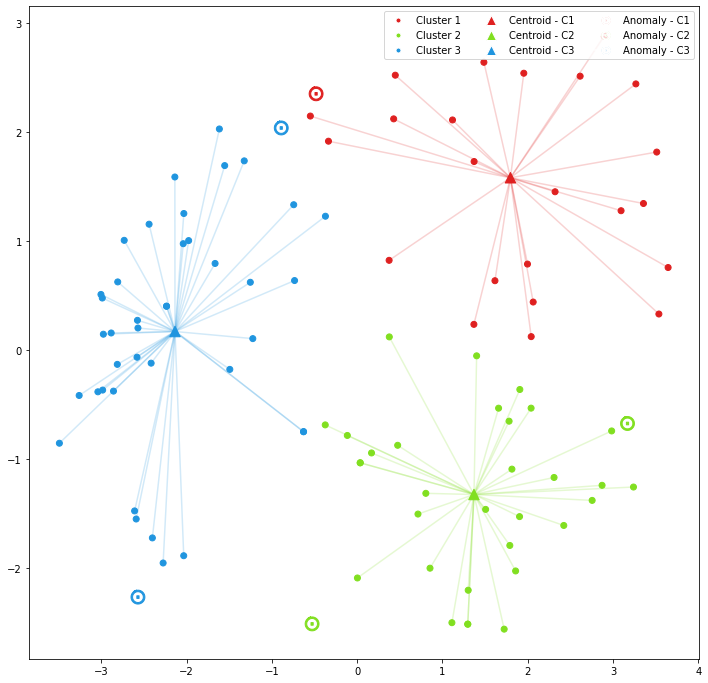

mean time :  0.612193722973813
total time :  891.3540606498718


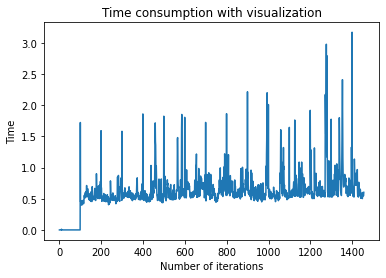

In [4]:
kmeans_results = evaluate(stream=iter_pandas(X=X, y=Y),
            model=kmean)